In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

import numpy as np
import matplotlib.pyplot as plt
import os, shutil, pathlib
import random

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


**Resuidual Connection**

*Residual bocks where no of filters changes*

In [3]:
inputs = keras.Input(shape=(32,32,3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)

x = layers.add([x, residual])

*Residual bocks where the target block includes a max pooling layer*

In [4]:
inputs = keras.Input(shape=(32,32,3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# adding strides=2 to balance with max pooling layer
residual = layers.Conv2D(64, 1, strides=2)(residual)

x = layers.add([x, residual])

*Convnets with Residual blocks in action*

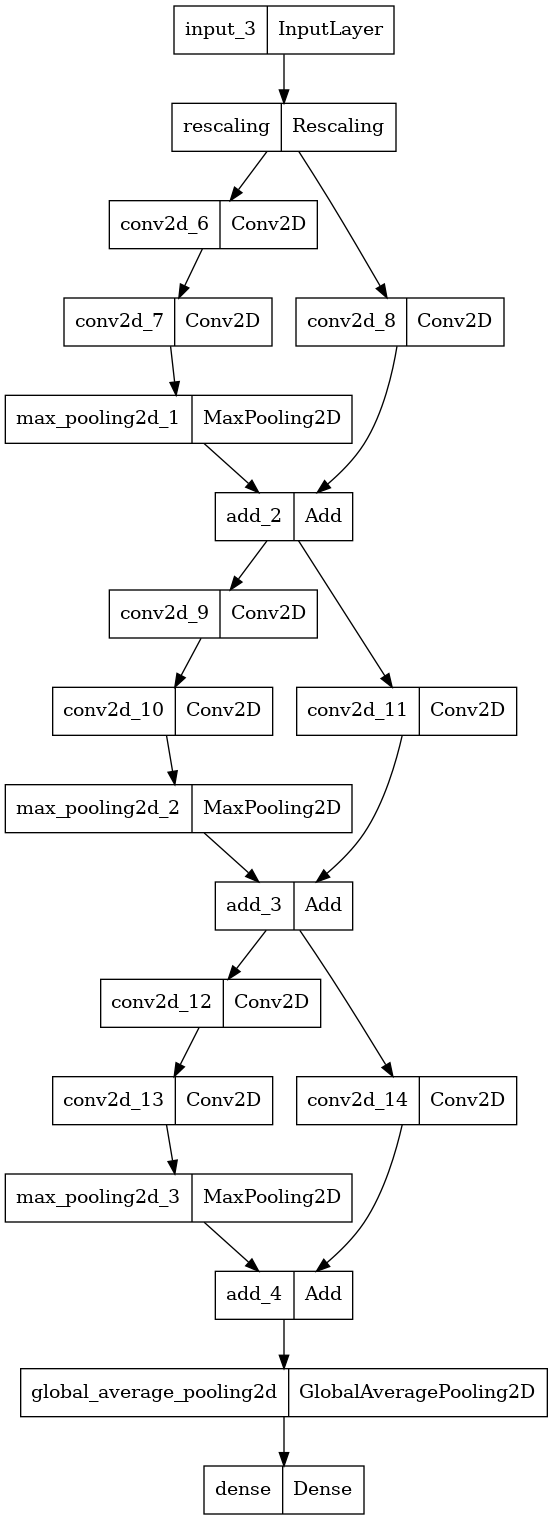

In [5]:
def residual_blocks(x, filters, pooling=False):

    residual = x

    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)

    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filter, 1)(residual)
    
    x = layers.add([x, residual])

    return x



inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)

x =  residual_blocks(x, filters=32, pooling=True)
x =  residual_blocks(x, filters=64, pooling=True)
x =  residual_blocks(x, filters=128, pooling=True)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

keras.utils.plot_model(model)

**Batch Normalization**

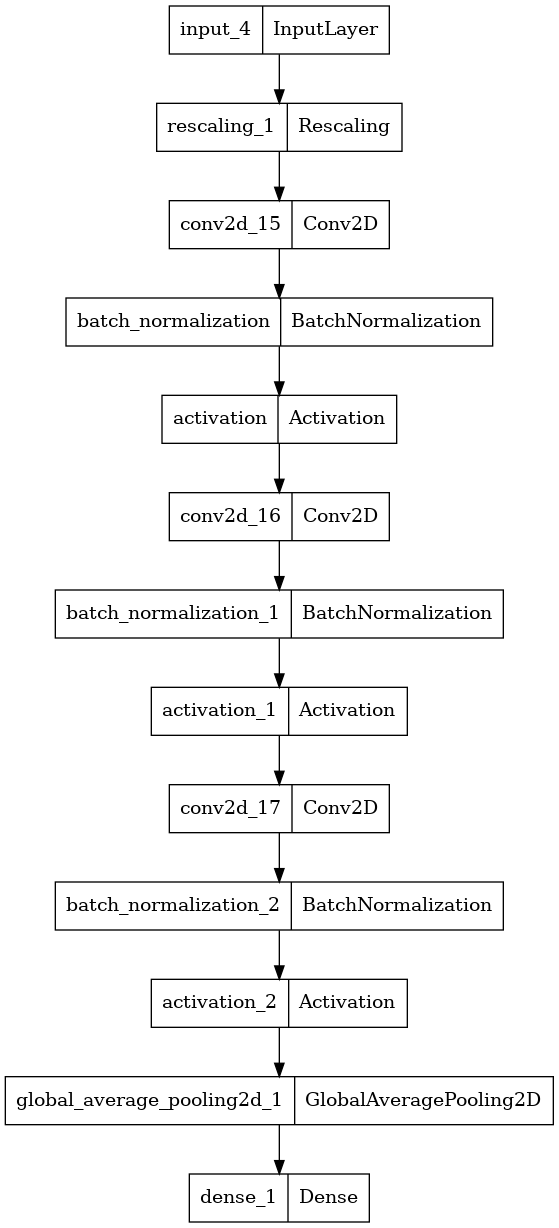

In [6]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

keras.utils.plot_model(model)

**Mini Xception**

In [14]:
orginal_dir = pathlib.Path("/home/ashok/workspace/dataset/PetImages/")
new_base_dir = pathlib.Path("/home/ashok/workspace/dataset/cats_vs_dogs_small/")

In [15]:
# calling image_dataset_from_directory function will list the sub-directories & assume each as a single class
# this function returns tf.data.Dataset object

train_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"train",
    image_size=(180,180),
    batch_size=32
)

val_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"validation",
    image_size=(180,180),
    batch_size=32
)

test_dataset = keras.utils.image_dataset_from_directory(
    new_base_dir/"test",
    image_size=(180,180),
    batch_size=32
)

Found 1875 files belonging to 2 classes.
Found 941 files belonging to 2 classes.
Found 1862 files belonging to 2 classes.


In [16]:
data_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [17]:
inputs = keras.Input(shape=(180,180,3))
x = data_aug(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:

    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3,padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3,padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same",)(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/ch09-adv-computer-vision/xception.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7547

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 361ms/step - loss: 0.5162 - accuracy: 0.7547 - val_loss: 0.7426 - val_accuracy: 0.5962
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7467

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 359ms/step - loss: 0.5067 - accuracy: 0.7467 - val_loss: 1.7821 - val_accuracy: 0.5409
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.7707

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 359ms/step - loss: 0.4829 - accuracy: 0.7707 - val_loss: 0.6453 - val_accuracy: 0.7024
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.7936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 359ms/step - loss: 0.4728 - accuracy: 0.7936 - val_loss: 0.5161 - val_accuracy: 0.7736
Epoch 5/100
59/59 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.7984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 358ms/step - loss: 0.4519 - accuracy: 0.7984 - val_loss: 0.5868 - val_accuracy: 0.7269
Epoch 6/100
59/59 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.8064

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 363ms/step - loss: 0.4336 - accuracy: 0.8064 - val_loss: 0.8015 - val_accuracy: 0.6472
Epoch 7/100
59/59 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8032

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 359ms/step - loss: 0.4290 - accuracy: 0.8032 - val_loss: 0.6869 - val_accuracy: 0.6695
Epoch 8/100
59/59 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8085

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.4235 - accuracy: 0.8085 - val_loss: 0.4601 - val_accuracy: 0.7800
Epoch 9/100
59/59 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8123

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 365ms/step - loss: 0.4019 - accuracy: 0.8123 - val_loss: 0.5667 - val_accuracy: 0.7513
Epoch 10/100
59/59 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8144

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 363ms/step - loss: 0.4256 - accuracy: 0.8144 - val_loss: 0.4210 - val_accuracy: 0.7960
Epoch 11/100
59/59 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8203

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 360ms/step - loss: 0.4027 - accuracy: 0.8203 - val_loss: 0.6044 - val_accuracy: 0.7194
Epoch 12/100
59/59 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8309

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 360ms/step - loss: 0.3813 - accuracy: 0.8309 - val_loss: 0.4588 - val_accuracy: 0.7896
Epoch 13/100
59/59 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8336

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 365ms/step - loss: 0.3874 - accuracy: 0.8336 - val_loss: 0.9657 - val_accuracy: 0.6791
Epoch 14/100
59/59 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8427

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.3593 - accuracy: 0.8427 - val_loss: 0.5953 - val_accuracy: 0.7683
Epoch 15/100
59/59 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8336

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 368ms/step - loss: 0.3753 - accuracy: 0.8336 - val_loss: 0.5085 - val_accuracy: 0.7609
Epoch 16/100
59/59 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8501

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 363ms/step - loss: 0.3458 - accuracy: 0.8501 - val_loss: 0.5653 - val_accuracy: 0.7598
Epoch 17/100
59/59 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8384

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 369ms/step - loss: 0.3700 - accuracy: 0.8384 - val_loss: 1.6550 - val_accuracy: 0.6217
Epoch 18/100
59/59 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8512

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.3363 - accuracy: 0.8512 - val_loss: 0.5704 - val_accuracy: 0.7460
Epoch 19/100
59/59 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8565

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 365ms/step - loss: 0.3325 - accuracy: 0.8565 - val_loss: 0.4033 - val_accuracy: 0.8140
Epoch 20/100
59/59 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8645

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.3151 - accuracy: 0.8645 - val_loss: 0.4167 - val_accuracy: 0.8130
Epoch 21/100
59/59 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8763

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.2976 - accuracy: 0.8763 - val_loss: 1.7726 - val_accuracy: 0.5781
Epoch 22/100
59/59 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8763

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.3023 - accuracy: 0.8763 - val_loss: 0.9773 - val_accuracy: 0.6196
Epoch 23/100
59/59 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8747

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 366ms/step - loss: 0.2867 - accuracy: 0.8747 - val_loss: 0.4374 - val_accuracy: 0.8332
Epoch 24/100
59/59 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8731

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 366ms/step - loss: 0.3021 - accuracy: 0.8731 - val_loss: 1.0175 - val_accuracy: 0.7163
Epoch 25/100
59/59 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.8805

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 368ms/step - loss: 0.2801 - accuracy: 0.8805 - val_loss: 0.4488 - val_accuracy: 0.8278
Epoch 26/100
59/59 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.8955

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 368ms/step - loss: 0.2549 - accuracy: 0.8955 - val_loss: 0.9420 - val_accuracy: 0.7428
Epoch 27/100
59/59 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.8949

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 374ms/step - loss: 0.2523 - accuracy: 0.8949 - val_loss: 0.3891 - val_accuracy: 0.8417
Epoch 28/100
59/59 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8763

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 370ms/step - loss: 0.2821 - accuracy: 0.8763 - val_loss: 0.4930 - val_accuracy: 0.7896
Epoch 29/100
59/59 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9061

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 368ms/step - loss: 0.2426 - accuracy: 0.9061 - val_loss: 0.5463 - val_accuracy: 0.7790
Epoch 30/100
59/59 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8885

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 373ms/step - loss: 0.2772 - accuracy: 0.8885 - val_loss: 0.3349 - val_accuracy: 0.8672
Epoch 31/100
59/59 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8885

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.2694 - accuracy: 0.8885 - val_loss: 0.5546 - val_accuracy: 0.8034
Epoch 32/100
59/59 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9056

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 361ms/step - loss: 0.2275 - accuracy: 0.9056 - val_loss: 0.3684 - val_accuracy: 0.8438
Epoch 33/100
59/59 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9008

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 366ms/step - loss: 0.2368 - accuracy: 0.9008 - val_loss: 0.7365 - val_accuracy: 0.6918
Epoch 34/100
59/59 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9019

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 360ms/step - loss: 0.2323 - accuracy: 0.9019 - val_loss: 0.5011 - val_accuracy: 0.8034
Epoch 35/100
59/59 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9024

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 362ms/step - loss: 0.2305 - accuracy: 0.9024 - val_loss: 0.5634 - val_accuracy: 0.8045
Epoch 36/100
59/59 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.8992

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.2375 - accuracy: 0.8992 - val_loss: 0.8702 - val_accuracy: 0.6738
Epoch 37/100
59/59 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9029

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 363ms/step - loss: 0.2458 - accuracy: 0.9029 - val_loss: 0.4219 - val_accuracy: 0.8310
Epoch 38/100
59/59 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9051

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 363ms/step - loss: 0.2375 - accuracy: 0.9051 - val_loss: 0.3618 - val_accuracy: 0.8608
Epoch 39/100
59/59 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9189

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 363ms/step - loss: 0.2160 - accuracy: 0.9189 - val_loss: 0.4095 - val_accuracy: 0.8565
Epoch 40/100
59/59 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9157

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 366ms/step - loss: 0.2005 - accuracy: 0.9157 - val_loss: 0.4415 - val_accuracy: 0.8470
Epoch 41/100
59/59 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9152

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 365ms/step - loss: 0.2095 - accuracy: 0.9152 - val_loss: 0.5949 - val_accuracy: 0.8045
Epoch 42/100
59/59 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9163

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 365ms/step - loss: 0.2133 - accuracy: 0.9163 - val_loss: 0.3910 - val_accuracy: 0.8629
Epoch 43/100
59/59 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9200

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 361ms/step - loss: 0.2029 - accuracy: 0.9200 - val_loss: 0.3877 - val_accuracy: 0.8363
Epoch 44/100
59/59 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9125

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 22s 367ms/step - loss: 0.1980 - accuracy: 0.9125 - val_loss: 0.3236 - val_accuracy: 0.8735
Epoch 45/100
59/59 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9163

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


59/59 [==============================] - 21s 361ms/step - loss: 0.1967 - accuracy: 0.9163 - val_loss: 0.4147 - val_accuracy: 0.8555
Epoch 46/100
38/59 [==================>...........] - ETA: 7s - loss: 0.1586 - accuracy: 0.9359

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

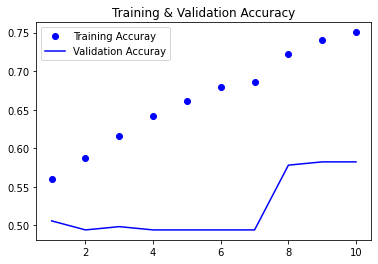

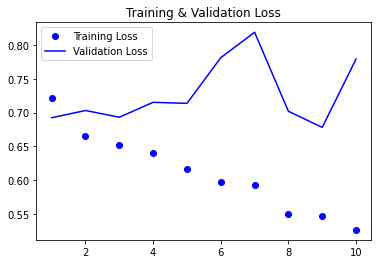

<Figure size 432x288 with 0 Axes>

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training Accuray")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuray")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.figure()

In [25]:
test_model = keras.models.load_model("checkpoints/ch09-adv-computer-vision/xception.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"test accuracy: {test_acc:.3f}")

25/59 [===========>..................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


59/59 [==============================] - 2s 30ms/step - loss: 0.3675 - accuracy: 0.8695
test accuracy: 0.869


In [26]:
from numba import cuda
cuda.select_device(0)
cuda.close()